#### Preparation

In [1]:
# (basic) dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm as tqdm

In [2]:
"""Create the required folders: `data`, `models`, `figures` and `results`. """
import os
# create required folders
folders = ['data', 'models', 'figures', 'results']
for folder_path in folders:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
print("Folders {} are available. ".format(folders))

Folders ['data', 'models', 'figures', 'results'] are available. 


# Particle Process Discriminator - Data Exporation and Preprocessing

In [3]:
# construct column names for n objects (empty columns are trimmed later on)
max_num_objects = 25 # have one event with 18 objects, add some for compality (and a weird seperator issue)
col_names = ['event ID', 'process ID', 'event weight', 'MET', 'METphi']
[col_names.extend(["obj{}".format(i), "E{}".format(i), 
                   "pt{}".format(i), "eta{}".format(i), 
                   "phi{}".format(i)]) for i in range(1, 1+max_num_objects)]

# load the train and validation data
# two delimiters are used: ';' and ','
# the latter seperates the object-specific quantities
# the regex delimiter below splits the data completely
data = pd.read_csv("data/TrainingValidationData.csv", header=None, index_col=0,
                    names=col_names, sep="[,;]", engine='python')

# filter all-NaN columns (i.e. trim unused object columns)
mask = data.isna().all() # columns will all NaN
data = data.loc[:, ~mask]
col_names = data.columns

# describe data set
data.describe()

,event weight,MET,METphi,E1,pt1,eta1,phi1,E2,pt2,eta2,...,eta16,phi16,E17,pt17,eta17,phi17,E18,pt18,eta18,phi18
count,1.000000e+05,1.000000e+05,100000.000000,9.999700e+04,9.999700e+04,99997.000000,99997.000000,9.992600e+04,9.992600e+04,99926.000000,...,27.000000,27.000000,5.000000,5.000000,5.000000,5.000000,1.0,1.0,1.000000,1.00000
mean,2.768161e-03,6.555098e+04,-0.002388,3.277655e+05,1.545569e+05,-0.003555,0.007387,2.502158e+05,1.077661e+05,0.002952,...,0.211409,0.035686,156263.780000,50542.640000,-1.153199,0.969473,27954.3,26642.3,0.244475,-1.76296
std,6.546279e-03,6.264809e+04,1.815031,2.992857e+05,1.123455e+05,1.350584,1.810318,2.563849e+05,7.614375e+04,1.422386,...,1.918930,1.716581,166601.271942,54383.872168,1.691099,1.246147,NaN,NaN,NaN,NaN
min,1.931320e-07,1.574180e+02,-3.141550,2.089250e+04,1.838530e+04,-4.856300,-3.141520,1.087540e+04,1.007280e+04,-4.788360,...,-3.939780,-2.555390,32726.900000,23929.500000,-3.514450,-0.453093,27954.3,26642.3,0.244475,-1.76296
25%,1.676350e-03,2.466452e+04,-1.577830,1.371900e+05,8.806960e+04,-0.987878,-1.553980,9.961972e+04,6.373630e+04,-1.009580,...,-0.932385,-1.320945,33950.000000,24275.200000,-2.145130,0.262300,27954.3,26642.3,0.244475,-1.76296
50%,1.676960e-03,4.691390e+04,-0.001953,2.262300e+05,1.196960e+05,-0.003297,0.008066,1.640690e+05,8.635380e+04,-0.002509,...,0.418514,-0.510212,103791.000000,25866.300000,-0.862300,0.573726,27954.3,26642.3,0.244475,-1.76296
75%,1.677790e-03,8.535605e+04,1.571882,4.073950e+05,1.774540e+05,0.987178,1.571920,2.999222e+05,1.248410e+05,1.014055,...,1.488130,1.224580,175907.000000,30944.200000,0.147273,1.818640,27954.3,26642.3,0.244475,-1.76296
max,3.350260e-02,1.016650e+06,3.141470,3.783780e+06,1.768980e+06,4.796060,3.141590,4.379710e+06,1.687820e+06,4.810550,...,3.283520,3.140950,434944.000000,147698.000000,0.608614,2.645790,27954.3,26642.3,0.244475,-1.76296


**Convert target label to true/false**  
A '4top' event is a positive event, while 'ttbar' is background. 

In [4]:
data['target'] = (data['process ID'] == '4top')
data['target'].value_counts()

# drop original column
data.drop(['process ID'], axis=1, inplace=True)

In [5]:
data['target'].value_counts()

False    83300
True     16700
Name: target, dtype: int64

In [6]:
counts = data['target'].value_counts()
print("Baseline accuracy (random guessing with statistics/always predict background): {}".format( counts.max() / (data.index.size) ))

Baseline accuracy (random guessing with statistics/always predict background): 0.833


## Correlations between input features
Show features of event-level and first three objects, and target label. 

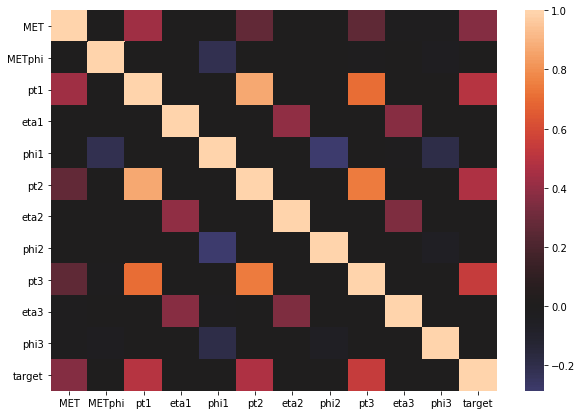

In [7]:
f, ax = plt.subplots(1, 1, figsize = (10, 7))
corr = data.filter(regex='MET|[a-z][1-3]$|target').corr() # change second number to include more/less objects
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, center=0)
plt.show()

As can be seen, several features have high correlation between eachother. Furthermore, the 'missing' energy MET and transverse momenta seem to have relatively high correlation with the target label. These quantities also have high correlation between eachother, so a (very) basic distriminator would not need all of these. 

## Distribution of features with high correlation with the target label
The distribution of features from background events are plotted with another color. 

Plotting Index(['pt4', 'pt3', 'pt5'], dtype='object')


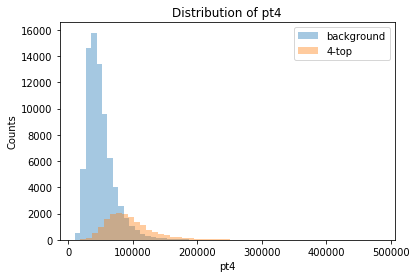

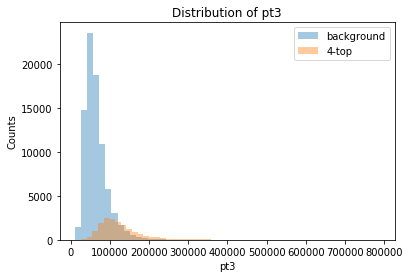

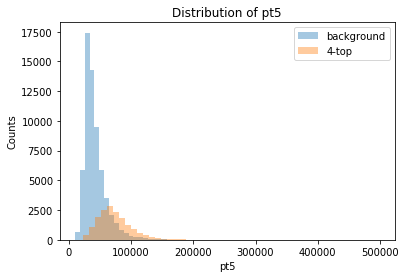

In [8]:
# sns.pairplot(train) # takes too long 

# calculate correlations and select the features with highest correlation with the target label
# only include features with at least 2000 non-NaN values
mask = ((~data.isna()).sum() > 2000)
corr = data.loc[:,mask].corr()
corr_target = corr['target']
corr_target = corr_target.abs().sort_values(ascending=False)
highcor_labels = corr_target.index[1:3+1]
print("Plotting", highcor_labels)

for col in highcor_labels:
    for label in [0, 1]:
        # select relevant columns from events of either background/signal
        labels = ['background', '4-top']
        mask = (data['target'] == label)
        # filter NaN 
        target_data = data.loc[mask, col]
        mask = target_data.isna()
        # plot distribution
        sns.distplot(target_data.loc[~mask], kde=False, label=labels[label])
    
    plt.legend()
    plt.title("Distribution of {}".format(col))
    plt.ylabel("Counts")
    plt.show()

The transverse momentum quantities seem to be important for discriminating the 4-top event. As can be seen above, the distributions have long tails, possibly benefitting from a log-transformation before being used as input. This is probably most important when employing neural networks. 

## Feature engineering: log-transform for quantities with long tails
As pointed out, the pt columns have long tails. The MET and E columns also have long tails (not shown). 

In [9]:
# create list of MET, E1, pt1, E2, pt2, ...
logtransform_features = ['MET']
[logtransform_features.extend(['E{}'.format(i), 'pt{}'.format(i)])
    for i in range(1, 1+max_num_objects)]

print("Taking log of {} (if available)".format(logtransform_features))

for i, feat in enumerate(logtransform_features):
    if feat in data.columns:
        data['{}_log'.format(feat)] = np.log(data[feat])

Taking log of ['MET', 'E1', 'pt1', 'E2', 'pt2', 'E3', 'pt3', 'E4', 'pt4', 'E5', 'pt5', 'E6', 'pt6', 'E7', 'pt7', 'E8', 'pt8', 'E9', 'pt9', 'E10', 'pt10', 'E11', 'pt11', 'E12', 'pt12', 'E13', 'pt13', 'E14', 'pt14', 'E15', 'pt15', 'E16', 'pt16', 'E17', 'pt17', 'E18', 'pt18', 'E19', 'pt19', 'E20', 'pt20', 'E21', 'pt21', 'E22', 'pt22', 'E23', 'pt23', 'E24', 'pt24', 'E25', 'pt25'] (if available)


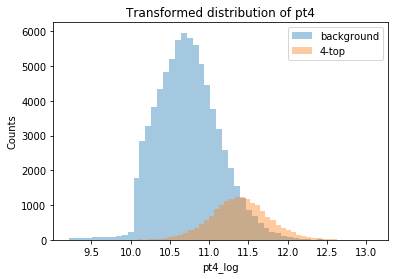

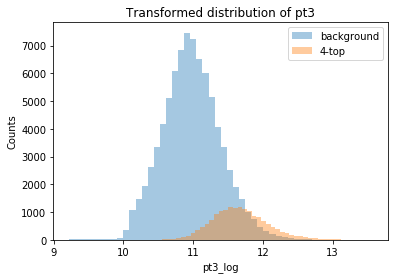

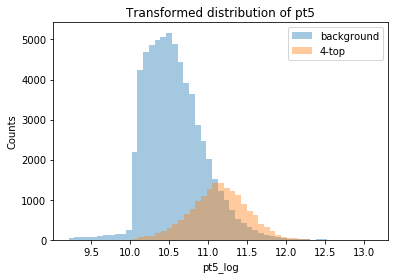

In [10]:
for col in highcor_labels:
    for label in [0, 1]:
        # select relevant columns from events of either background/signal
        labels = ['background', '4-top']
        mask = (data['target'] == label)
        # filter NaN 
        target_data = data.loc[mask, "{}_log".format(col)]
        mask = target_data.isna()
        # plot distribution
        sns.distplot(target_data.loc[~mask], kde=False, label=labels[label])
    
    plt.legend()
    plt.title("Transformed distribution of {}".format(col))
    plt.ylabel("Counts")
    plt.show()

## Convert categorical columns to one-hot encoding
The obj columns contain the identifier of the object, e.g. electron (e), photon (p), muon (m), ...
These strings pose a problem for neural networks, and should not interfere with decision trees. 

In [11]:
one_hot_columns = ['obj{}'.format(i) for i in range(1, 1+max_num_objects)]
df = data

for col in one_hot_columns:
    if col in df.columns:
        print("Converting {} to one-hot encoding".format(col))
        # convert to one-hot encoding
        onehot = pd.get_dummies(df[col], prefix=col)
        
        # merge with dataset
        df = pd.merge(onehot, df, left_index=True, right_index=True)
        # df.drop(col, axis=1, inplace=True)

data = df
df.describe().transpose()

Converting obj1 to one-hot encoding
Converting obj2 to one-hot encoding
Converting obj3 to one-hot encoding
Converting obj4 to one-hot encoding
Converting obj5 to one-hot encoding
Converting obj6 to one-hot encoding
Converting obj7 to one-hot encoding
Converting obj8 to one-hot encoding
Converting obj9 to one-hot encoding
Converting obj10 to one-hot encoding
Converting obj11 to one-hot encoding
Converting obj12 to one-hot encoding
Converting obj13 to one-hot encoding
Converting obj14 to one-hot encoding
Converting obj15 to one-hot encoding
Converting obj16 to one-hot encoding
Converting obj17 to one-hot encoding
Converting obj18 to one-hot encoding


,count,mean,std,min,25%,50%,75%,max
obj18_j,100000.0,0.000010,0.003162,0.000000,0.000000,0.000000,0.000000,1.000000
obj17_b,100000.0,0.000020,0.004472,0.000000,0.000000,0.000000,0.000000,1.000000
obj17_j,100000.0,0.000020,0.004472,0.000000,0.000000,0.000000,0.000000,1.000000
obj17_m-,100000.0,0.000010,0.003162,0.000000,0.000000,0.000000,0.000000,1.000000
obj16_b,100000.0,0.000010,0.003162,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
pt16_log,27.0,10.381184,0.420251,10.026413,10.121113,10.176712,10.429934,11.571685
E17_log,5.0,11.487883,1.105996,10.395953,10.432644,11.550135,12.077711,12.982973
pt17_log,5.0,10.516728,0.781630,10.082867,10.097211,10.160696,10.339941,11.902925
E18_log,1.0,10.238326,NaN,10.238326,10.238326,10.238326,10.238326,10.238326


## Alternative: convert categorical to numerical categories

In [12]:
vals = np.ravel(data.filter(regex='obj\d+$').values).astype('str') # select obj1, obj2, .., but not obj1_b columns
labels = np.unique([v for v in vals if v != 'None' and v != 'nan']) # select unique occurences, not being nonsense
label_conv = {labels[i]: i for i in range(len(labels))} # create mapping value -> num
print("Converting obj features: \n{}".format(label_conv))

Converting obj features: 
{'b': 0, 'e+': 1, 'e-': 2, 'g': 3, 'j': 4, 'm+': 5, 'm-': 6}


Additionally, NaN values are mapped to -1. 

In [13]:
num_columns = ['obj{}'.format(i) for i in range(1, 1+max_num_objects)]
df = data

for col in num_columns:
    if col in df.columns:
        print("Converting {} to numerical encoding".format(col))
        # for each column: 1. convert to category and 2. get category codes
        df['{}_num'.format(col)] = data[col].astype('category').cat.codes

data = df
df.describe().transpose()

Converting obj1 to numerical encoding
Converting obj2 to numerical encoding
Converting obj3 to numerical encoding
Converting obj4 to numerical encoding
Converting obj5 to numerical encoding
Converting obj6 to numerical encoding
Converting obj7 to numerical encoding
Converting obj8 to numerical encoding
Converting obj9 to numerical encoding
Converting obj10 to numerical encoding
Converting obj11 to numerical encoding
Converting obj12 to numerical encoding
Converting obj13 to numerical encoding
Converting obj14 to numerical encoding
Converting obj15 to numerical encoding
Converting obj16 to numerical encoding
Converting obj17 to numerical encoding
Converting obj18 to numerical encoding


,count,mean,std,min,25%,50%,75%,max
obj18_j,100000.0,0.00001,0.003162,0.0,0.0,0.0,0.0,1.0
obj17_b,100000.0,0.00002,0.004472,0.0,0.0,0.0,0.0,1.0
obj17_j,100000.0,0.00002,0.004472,0.0,0.0,0.0,0.0,1.0
obj17_m-,100000.0,0.00001,0.003162,0.0,0.0,0.0,0.0,1.0
obj16_b,100000.0,0.00001,0.003162,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
obj14_num,100000.0,-0.98369,0.289180,-1.0,-1.0,-1.0,-1.0,6.0
obj15_num,100000.0,-0.99546,0.151656,-1.0,-1.0,-1.0,-1.0,6.0
obj16_num,100000.0,-0.99877,0.078029,-1.0,-1.0,-1.0,-1.0,6.0
obj17_num,100000.0,-0.99991,0.013784,-1.0,-1.0,-1.0,-1.0,2.0


## Drop obj columns
All information is contained in either the one-hot or numerical representation. 

In [14]:
drop_features = data.filter(regex='obj\d+$')
data.drop(columns=drop_features, inplace=True)

## Zero padding for NaN values
Omit columns `obj`, because those column contains strings and are not relevant anymore. The derived columns, `objx_num` and `objx_y`, do not contain NaN due to their respective setup. This is checked below. 

In [15]:
data.filter(regex='obj\d+_').isna().sum().sum()

0

In [16]:
columns = [col for col in data.columns if 'obj' not in col]

for col in columns:
    # select NaN values
    mask = data[col].isna()
    # and set to zero
    data.loc[mask, col] = 0

## Normalize

In [17]:
# select features for normalization
# selects objx_num, objx_y, MET, METphi, E1, E1_log, ...
features = data.filter(regex='obj\d+_|MET|E|pt|phi|eta').columns

In [18]:
print("Not included in features are: \n{}".format(data.columns.difference(features)))

Not included in features are: 
Index(['event weight', 'target'], dtype='object')


Which is as it should be, as the obj features are either used as categorical number or as one-hot encoding. 

### Min-max normalization to [-1, 1] interval

In [19]:
# copy data
data_norm = data.copy()

print("Normalizing..")
# calculate normalization constants for all features
norm = data[features].abs().max()

# devide values by norm
data_norm[features] = data_norm[features] / norm

# save normalized features and norm constants to file
print("Saving..")
data_norm.to_csv('data/data_minmax.csv')
norm.to_csv('data/norm_minmax.csv', header=False)

# verify results
data_norm.describe()

Normalizing..
Saving..


,obj18_j,obj17_b,obj17_j,obj17_m-,obj16_b,obj16_e+,obj16_e-,obj16_g,obj16_j,obj16_m+,...,obj9_num,obj10_num,obj11_num,obj12_num,obj13_num,obj14_num,obj15_num,obj16_num,obj17_num,obj18_num
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.000010,0.000020,0.000020,0.000010,0.000010,0.000020,0.000030,0.000010,0.000160,0.000030,...,-0.052692,-0.097630,-0.129077,-0.148325,-0.159045,-0.163948,-0.165910,-0.166462,-0.499955,-0.999990
std,0.003162,0.004472,0.004472,0.003162,0.003162,0.004472,0.005477,0.003162,0.012648,0.005477,...,0.285806,0.230767,0.174541,0.123476,0.080174,0.048197,0.025276,0.013005,0.006892,0.003162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.500000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.500000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.500000,-1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.500000,-1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


### Z-score normalization to zero mean, unit variance
For all values: 
$new = \frac{old - mean}{std}$, with the mean and standard deviation calculated per parameter. 

In [20]:
# copy data
data_norm = data.copy()

# calculate statistics
print("Normalizing..")
mean = data_norm[features].mean()
std = data_norm[features].std(ddof=0)

# calculate new values
data_norm[features] = (data_norm[features] - mean) / std

# save results
print("Saving..")
data_norm.to_csv('data/data_zscore.csv')
mean.to_csv('data/zscore_mean.csv', header=False)
std.to_csv('data/zscore_std.csv', header=False)

# verify results
data_norm.describe()

Normalizing..
Saving..


,obj18_j,obj17_b,obj17_j,obj17_m-,obj16_b,obj16_e+,obj16_e-,obj16_g,obj16_j,obj16_m+,...,obj9_num,obj10_num,obj11_num,obj12_num,obj13_num,obj14_num,obj15_num,obj16_num,obj17_num,obj18_num
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,-5.950795e-19,7.815970e-19,-1.669775e-18,-1.474376e-18,-1.225686e-18,-2.380318e-18,1.154632e-18,-1.598721e-18,1.037392e-17,3.570477e-18,...,-5.684342e-18,-4.973799e-17,1.605827e-17,1.747935e-17,-1.176303e-16,-1.571721e-16,7.851497e-17,5.985612e-16,-2.497273e-15,1.439409e-14
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-3.162293e-03,-4.472181e-03,-4.472181e-03,-3.162293e-03,-3.162293e-03,-4.472181e-03,-5.477308e-03,-3.162293e-03,-1.265012e-02,-5.477308e-03,...,-3.987861e-01,-2.991634e-01,-2.153661e-01,-1.485456e-01,-9.506501e-02,-5.640122e-02,-2.993627e-02,-1.576342e-02,-6.529425e-03,-3.162293e-03
25%,-3.162293e-03,-4.472181e-03,-4.472181e-03,-3.162293e-03,-3.162293e-03,-4.472181e-03,-5.477308e-03,-3.162293e-03,-1.265012e-02,-5.477308e-03,...,-3.987861e-01,-2.991634e-01,-2.153661e-01,-1.485456e-01,-9.506501e-02,-5.640122e-02,-2.993627e-02,-1.576342e-02,-6.529425e-03,-3.162293e-03
50%,-3.162293e-03,-4.472181e-03,-4.472181e-03,-3.162293e-03,-3.162293e-03,-4.472181e-03,-5.477308e-03,-3.162293e-03,-1.265012e-02,-5.477308e-03,...,-3.987861e-01,-2.991634e-01,-2.153661e-01,-1.485456e-01,-9.506501e-02,-5.640122e-02,-2.993627e-02,-1.576342e-02,-6.529425e-03,-3.162293e-03
75%,-3.162293e-03,-4.472181e-03,-4.472181e-03,-3.162293e-03,-3.162293e-03,-4.472181e-03,-5.477308e-03,-3.162293e-03,-1.265012e-02,-5.477308e-03,...,-3.987861e-01,-2.991634e-01,-2.153661e-01,-1.485456e-01,-9.506501e-02,-5.640122e-02,-2.993627e-02,-1.576342e-02,-6.529425e-03,-3.162293e-03
max,3.162262e+02,2.236046e+02,2.236046e+02,3.162262e+02,3.162262e+02,2.236046e+02,1.825714e+02,3.162262e+02,7.905062e+01,1.825714e+02,...,3.683253e+00,4.756469e+00,6.468870e+00,9.300058e+00,1.445676e+01,2.415013e+01,4.612731e+01,8.969475e+01,2.176410e+02,3.162262e+02


## Convert dataset to images

### Conversion to image with $\eta$ and $\phi$ as coordinates
Each objects carries an energy and transverse momentum, which can be plotted as the two channels for pixel ($\eta$, $\phi$).  
The object type (obj, electron (e), etc.) is categorical input which can be vectorized in several ways. For a dense network one-hot encoding is a default choice, but adding many channels to the image does not seem practical.  

For exploratory purposes and size constraints, the block below will create an image with a single layer, with each pixel representing whether an object is present or not. In later stages this will be extended, but that will be done in the respective notebook due to large file size. 

In [22]:
data_norm = pd.read_csv('data/data_minmax.csv')

In [23]:
data_norm.describe()

,event ID,obj18_j,obj17_b,obj17_j,obj17_m-,obj16_b,obj16_e+,obj16_e-,obj16_g,obj16_j,...,obj9_num,obj10_num,obj11_num,obj12_num,obj13_num,obj14_num,obj15_num,obj16_num,obj17_num,obj18_num
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,0.000010,0.000020,0.000020,0.000010,0.000010,0.000020,0.000030,0.000010,0.000160,...,-0.052692,-0.097630,-0.129077,-0.148325,-0.159045,-0.163948,-0.165910,-0.166462,-0.499955,-0.999990
std,28867.657797,0.003162,0.004472,0.004472,0.003162,0.003162,0.004472,0.005477,0.003162,0.012648,...,0.285806,0.230767,0.174541,0.123476,0.080174,0.048197,0.025276,0.013005,0.006892,0.003162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.500000,-1.000000
25%,24999.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.500000,-1.000000
50%,49999.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.500000,-1.000000
75%,74999.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.500000,-1.000000
max,99999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [24]:
# check selection of as coordinates for the images
cols = data_norm.filter(regex='eta[0-9]|phi[0-9]'.format(2)).columns
cols

Index(['eta1', 'phi1', 'eta2', 'phi2', 'eta3', 'phi3', 'eta4', 'phi4', 'eta5',
       'phi5', 'eta6', 'phi6', 'eta7', 'phi7', 'eta8', 'phi8', 'eta9', 'phi9',
       'eta10', 'phi10', 'eta11', 'phi11', 'eta12', 'phi12', 'eta13', 'phi13',
       'eta14', 'phi14', 'eta15', 'phi15', 'eta16', 'phi16', 'eta17', 'phi17',
       'eta18', 'phi18'],
      dtype='object')

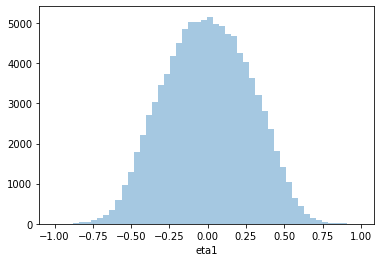

In [25]:
# check distribution of one such coordinate
sns.distplot(data_norm[cols[0]], kde=False)

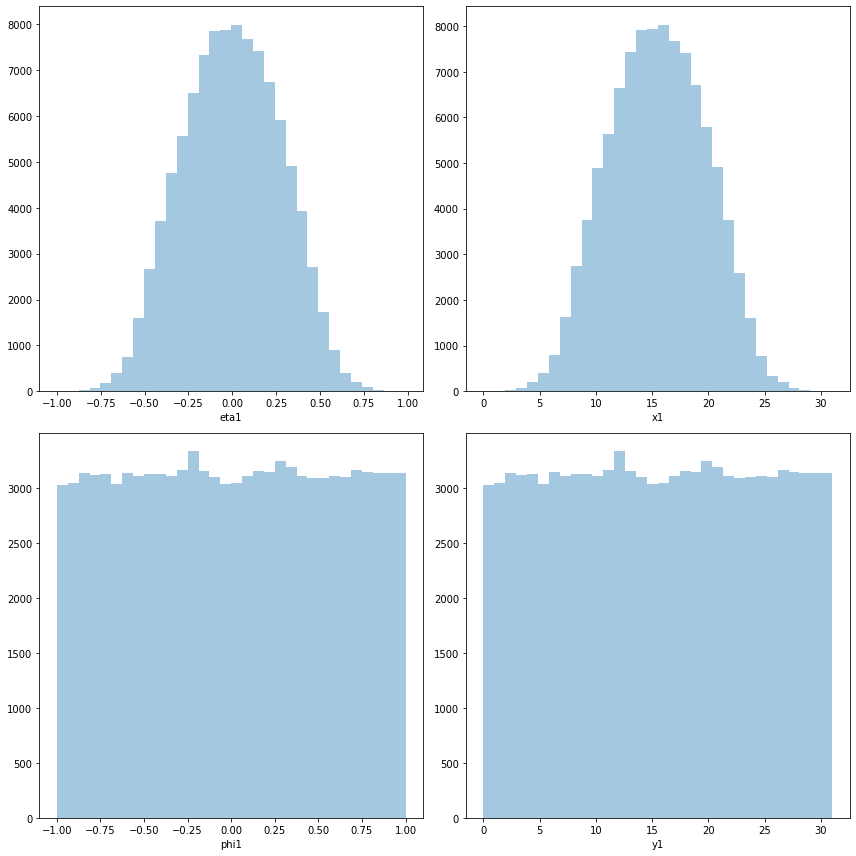

100%|██████████| 100000/100000 [00:53<00:00, 1877.41it/s]


In [26]:
def obj_angles_to_single_channel_images(df, nx=32, ny=32, max_num_objects=25, xmin=-1, xmax=1, ymin=-1, ymax=1):
    # prevent changing input
    df = df.copy()

    # initialize images
    images = np.zeros(shape=(df.index.size, ny, nx, 1))

    # calculate pixel positions of objects
    # bin eta values onto the pixels in x-direction
    xbins = np.linspace(xmin, xmax, num=nx+1)
    xlabels = range(nx)
    # bin phi values onto the pixels in y-direction
    ybins = np.linspace(ymin, ymax, num=ny+1)
    ylabels = range(ny)

    # bin eta and phi to the bins specified above
    for i in range(1, 1+max_num_objects):
        # eta and phi need to be binned, for each object
        df['x{}'.format(i)] = pd.cut(df['eta{}'.format(i)], bins=xbins, labels=xlabels)
        df['y{}'.format(i)] = pd.cut(df['phi{}'.format(i)], bins=ybins, labels=ylabels)
    
    f, axes = plt.subplots(2, 2, figsize=(12, 12))
    sns.distplot(df['eta1'], bins=nx, ax=axes[0, 0], kde=False)
    sns.distplot(df['x1'], bins=nx, ax=axes[0, 1], kde=False)
    sns.distplot(df['phi1'], bins=nx, ax=axes[1, 0], kde=False)
    sns.distplot(df['y1'], bins=nx, ax=axes[1, 1], kde=False)
    plt.tight_layout()
    plt.show()

    # create images
    for nr, (idx, row) in tqdm(enumerate(df.iterrows()), total=df.index.size):
        # create image from event data
        for i in range(1, 1+max_num_objects):
            x, y = row['x{}'.format(i)], row['y{}'.format(i)]
            if not np.isnan(x) and not np.isnan(y):
                x, y = int(x), int(y)
                # due to the zero padding, many values are zero instead of NaN
                if not (x == 0 and y==0):
                    images[nr, y, x] = 1

    return images

# calculate span of eta and phi
xmin, xmax = data_norm.filter(regex='^eta').min().min(), data_norm.filter(regex='^eta').max().max()
ymin, ymax = data_norm.filter(regex='^phi').min().min(), data_norm.filter(regex='^phi').max().max()

# create images
images = obj_angles_to_single_channel_images(data_norm, max_num_objects=18, 
                                             xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

In [28]:
np.save("data/images_1ch.npy", images)

More pipelines for creating images are implemented in `Train Convolutional Neural Networks.ipynb` directly, to avoid saving many large files to disk. 